
# Engenharia do Lucro: Pipeline de Dados ETL para Marketing Inteligente em Lavanderia Self-Service

Curso: Pós-graduação Lato Sensu em Data Science & Analytics (PUC-Rio) </br>
Aluna: **Isabela Costa Ferreira da Silva**</br>
Matrícula: 


## 1️⃣ Objetivo

Este MVP tem como objetivo construir o **pipeline de dados** para analisar o comportamento de consumo dos usuários de uma lavanderia self-service, onde o cliente realiza todos os serviços de forma autônoma, desde o cadastro, pagamento, uso das máquinas, até a dobradura das suas próprias roupas. 




 




**Contexto de negócio**

Antes de prover qualquer insight ou análise, é preciso que o dado passe por diversas etapas. Nosso intuito é, portanto, extrair, transformar e carregar os dados referentes algumas das análises que fazem parte da nossa rotina para aumentar a lucratividade através de **campanhas de marketing mais eficazes**!





Logo, responderemos às seguintes <a name="perguntas">perguntas de negócio</a> durante a nossa trajetória:

- qual o **ticket médio** do clientes, ou seja, qual a média de consumo mensal em reais;
- métrica de **_ROAS_** (retorno sobre anúncios pagos) para entender se estamos tendo lucro ou prejuízo com esse investimento.
- saber quem são os **top 20 clientes** que mais consomem para que possamos engajá-los com programas de fidelidade e até premiações;
- total de **novos usuários** adquiridos por mês para acompanhar a eficácia das campanhas e enxergar se há outliers e o porquê dos mesmos.

**Etapas**

Utilizamos a **arquitetura medalhão** como boa prática neste trabalho, de forma que o fluxo e qualidade de dados vá progredindo ao longo das etapas descritas a seguir. 

O presente trabalho teve as seguintes etapas:

 1 - download das tabelas do sistema ERP; </br>

 2 - _Mascaramos_ os dados sensíveis [aqui](https://github.com/isabelacfs/MVP_Data_Engineering/blob/main/faker_mvp_engenharia.ipynb) neste notebook;</br>

 3 - Armazenamos as tabelas (raw) em volumes do próprio Databricks;</br>

 4 - 🥉 Realizamos a ingestão e carga dos dados na camada **bronze**;

 5 - 🥈 Fizemos limpezas necessárias, transformações, _joins_ e persistimos na camada **prata**;

 6 - 🥇 Na camada **ouro**, temos a nossa _Analytic Base Table - ABT_ para responder às [perguntas de negócio](#perguntas) estabelecidas;
 
 7 - Procedemos à visualização dos dados com as principais métricas de negócio à mão.


## 2️⃣ Sobre os Dados

**Fonte de dados e coleta**

A fonte de dados foram obtidas através dos sistemas de telemetria, que são por sua vez, armazenados na nuvem. O dado original foi mascarado para manter a confidencialidade, mas a estrutura original de tabelas e atributos foram mantidos, que são: cadastro de clientes e consumo mensal dos clientes.

- Tabela `consumo_cliente`: é a tabela fato, onde cada linha representa o consumo de um único usuário; 
- Tabela `cadastro_cliente`: como o próprio nome já diz, contém os dados pessoais que o cliente fornece.

**Modelagem**

Entre elas existe a relação 1:N, ou seja, um único usuário cadastrado pode ter diversas instâncias na tabela de consumo, o que nos possibilita realizar joins e formar um "_tabelão_" nas etapas seguintes que responderão a essas e outras perguntas de negócio e também fornecerão insumos para o nosso _Dashboard_.

(Link do diagrama no repositório do [Github](https://github.com/isabelacfs/MVP_Data_Engineering/blob/5b03bc842b5348c8d956d53491869b0f4196dfed/modelagem_de_dados.png))


![modelagem](/Volumes/mvp_catalog/mvp_schema/volumes/modelagem_de_dados.png)



**Catálogo de dados**

Tabela **`cadastro_cliente`**: contém os dados pessoais de todos os usuários do serviço e cada instância corresponde a um usuário específico no sistema.</br>


<table tabindex="0">
<thead>
<tr>
<th>Campo</th>
<th>Descrição</th>
<th>Datatype</th>
<th>Tamanho</th>
<th>Valores possíveis</th>
<th>Chave estrangeira</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>nome_cliente</code></td>
<td>nome completo do usuário e deve conter pelo menos o primeiro nome</td>
<td>string</td>
<td>200</td>
<td></td>
<td>-</td>
</tr>
<tr>
<td><code>id_cliente</code></td>
<td>Sequência de caracteres do tipo inteiro e contém o documento do cliente, é a chave primária (PK) da tabela.</td>
<td>integer</td>
<td>6</td>
<td>Identificadores únicos, ex.: 101804</td>
<td></td>
</tr>
<tr>
<td><code>telefone</code></td>
<td>número de telefone do usuário com DDD</td>
<td>string</td>
<td>50</td>
<td>-</td>
<td>-</td>
</tr>
<tr>
<td><code>dt_registro</code></td>
<td> data em que o usuário se cadastra no sistema</td>
<td>date</td>
<td>10</td>
<td>datas no formato 'aaaa-mm-dd hh:mm:ss', ex.: 2024-07-22 11:46:35</td>
<td></td>
</tr>
<tr>
<td><code>dt_nascimento</code></td>
<td>data de nascimento do usuário.</td>
<td>date</td>
<td>10</td>
<td>datas no formato 'aaaa-mm-dd hh:mm:ss', ex.:1976-06-29</td>
<td></td>
</tr>
</tbody>
</table>





Tabela **`consumo_diario`**: cada instância dessa tabela corresponde ao consumo por período (ano-mês) de cada usuário cadastrado no sistema.

<table tabindex="1">
<thead>
<tr>
<th>Campo</th>
<th>Descrição</th>
<th>Datatype</th>
<th>Tamanho</th>
<th>Valores possíveis</th>
<th>Chave estrangeira</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>id_cliente</code></td>
<td>chave estrangeira do tipo inteiro e identifica do cliente que realizou o consumo</td>
<td>string</td>
<td>200</td>
<td>-</td>
<td><code>cadastro_cliente.id_cliente</code></td>
</tr>
<tr>
<td><code>valor_compras</code></td>
<td> é o somatório de valor (em reais) de todas as compras realizadas pelos clientes no mês</td>
<td>float</td>
<td></td>
<td>ex.: 0.10, 19.09, 560.00</td>
<td>-</td>
</tr>
<tr>
<td><code>qtde_compras</code></td>
<td>é o somatório de ciclos feitos pelo clientes no mês</td>
<td>integer</td>
<td></td>
<td>ex.: 0, 1, 2, 3, etc.</td>
<td>-</td>
</tr>
<tr>
<td><code>periodo_consumo</code></td>
<td>É o mês e ano de consumo</td>
<td>date</td>
<td>9</td>
<td>datas no formato 'aaaa-mm', ex.: 2022-04</td>
<td>-</td>
</tr>
</tbody>
</table>


##3️⃣ Implementação


In [0]:
%sql
-- deletamos os bancos de dados, por precaução, caso existam, para depois criar novos esquema seguindo a arquitetura medalhão
DROP DATABASE IF EXISTS bronze CASCADE;
DROP DATABASE IF EXISTS silver CASCADE;
DROP DATABASE IF EXISTS gold CASCADE;

CREATE SCHEMA IF NOT EXISTS silver COMMENT 'Cria o schema silver';
CREATE SCHEMA IF NOT EXISTS gold COMMENT 'Cria o schema gold';
CREATE SCHEMA IF NOT EXISTS bronze COMMENT 'Cria o schema bronze';


### 🥉 Bronze | Ingestão e Carga

Fizemos a ingestão manual em um volume do catálogo e depois persistimos os dados, mesmo brutos, na cama bronze, como mostrado abaixo.

Primeiro, vamos realizar a importação da biblioteca pandas de manipualção e análise de dados do python e carregamos os dados que foram armazenados nos volumes do Databricks.

In [0]:
# importação das bibliotecas para análise de dados pandas e pyspark que utilizamos para persistir os dados
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [0]:
# inicia sessão pyspark
# Inicializa Spark Session
spark = SparkSession.builder.appName("lavanderia").getOrCreate()

# definindo o caminho dos arquivos do volume
CONSUMO= '/Volumes/mvp_catalog/mvp_schema/volumes/consumo_clientes.csv'
CLIENTES = '/Volumes/mvp_catalog/mvp_schema/volumes/cadastro_clientes.csv'

# Lê os arquivos e cria os DataFrames
consumo_clientes = pd.read_csv(CONSUMO, index_col=False)
cadastro_clientes = pd.read_csv(CLIENTES, index_col=False)



In [0]:
cadastro_clientes.shape[0]

2705

In [0]:
# checando ocorrência de dados nulos
print('\n Dados nulos Percentual na tabela consumo_clientes \n', round(consumo_clientes.isnull().sum()/consumo_clientes.shape[0],2))
print('\n Dados nulos Percentual na tabela cadastro_clientes \n', round(cadastro_clientes.isnull().sum()/cadastro_clientes.shape[0],2))


 Dados nulos Percentual na tabela consumo_clientes 
 id_cliente         0.0
qtde_compras       0.0
valor_compras      0.0
periodo_consumo    0.0
dtype: float64

 Dados nulos Percentual na tabela cadastro_clientes 
 id_cliente       0.00
nome_cliente     0.00
telefone         0.00
dt_nascimento    0.39
dt_registro      0.00
dtype: float64


39% das datas de nascimento encontram-se nulas! 

Abaixo vamos dar uma olhada como se apresentam esses dados e informar que o sistema pode estar ou permitindo a inserção de datas sem validação de data ou que os mesmos foram corrompidos.

In [0]:
cadastro_clientes.loc[cadastro_clientes['dt_nascimento'].isnull()]

,id_cliente,nome_cliente,telefone,dt_nascimento,dt_registro
7,100008,Yago Leão,21 1898-4713,NaN,2025-07-26 18:16:47
10,100011,Otávio Fernandes,0900 078 5158,NaN,2025-09-27 15:46:50
11,100012,Eduardo Cunha,(011) 7342-5754,NaN,2025-02-05 17:45:08
13,100014,Luiz Henrique Ferreira,21 1837 6064,NaN,2025-07-31 18:05:54
14,100015,Julia Aparecida,(031) 1343 2756,NaN,2025-06-23 12:24:38
...,...,...,...,...,...
2696,102697,Pedro Ribeiro,+55 21 7555 9289,NaN,2025-08-26 18:51:57
2698,102699,Maria Liz da Cunha,51 2675 1199,NaN,2025-01-23 17:13:15
2699,102700,Sophie Marques,11 6453-4965,NaN,2025-10-05 14:57:02
2701,102702,Stella Cirino,51 9630 0935,NaN,2025-07-16 12:11:11


Vamos checar se existe um mês específico em que se registram datas de nascimento corrompidas. Assim poderemos ter uma pista do que aconteceu, se foram inseridas de propósito ou se "quebraram" devido a alguma atualização no sistema que guarda as informações. 

In [0]:
cadastro_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705 entries, 0 to 2704
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id_cliente     2705 non-null   int64 
 1   nome_cliente   2705 non-null   object
 2   telefone       2705 non-null   object
 3   dt_nascimento  1650 non-null   object
 4   dt_registro    2705 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.8+ KB


In [0]:
# transformar datas de nascimento e de registro em campos de data
cadastro_clientes['dt_nascimento'] = pd.to_datetime(cadastro_clientes['dt_nascimento'], format='%Y-%m-%d')
cadastro_clientes['dt_registro'] = pd.to_datetime(cadastro_clientes['dt_registro'])

In [0]:
# calcular ocorrências de datas de nascimento corrompidas por período de registro
cadastro_clientes.loc[cadastro_clientes['dt_nascimento'].isnull()]['dt_registro'].dt.to_period('M').value_counts()


dt_registro
2025-07    204
2025-05    160
2025-08    145
2025-06    129
2025-04    128
2025-02    102
2025-03     83
2025-09     55
2025-01     31
2025-10     10
2024-03      2
2024-08      2
2024-04      2
2024-05      1
2024-12      1
Freq: M, Name: count, dtype: int64

Aparentemente as datas de nascimento foram muito mais corrompidas entre janeiro e agosto de 2025. O que nos aponta alguma atualiazação ou nos campos de input do sistema ou no banco de dados da fonte e, ao que aparenta, os erros começaram a diminuir a partir de setembro. De fato é algo a ser apontado para o ERP responsável. 

**Outlier no valor de compras**

Percebemos que em alguma situações os clientes em determinados períodos consomem muito mais, muito além da média. Mas não é nenhuma surpresa dados os períodos em que o clima e o número de pessoas circulando na cidade movimenta a economia local.

<Axes: >

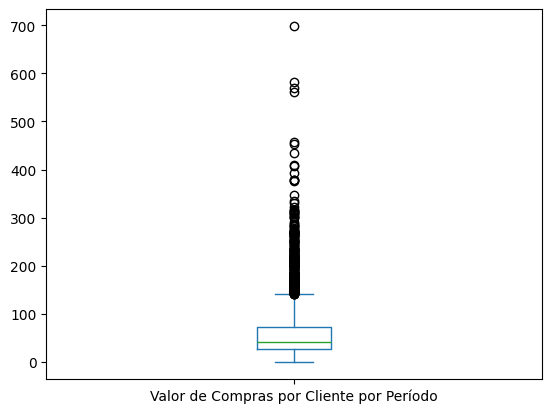

In [0]:
consumo_clientes.groupby(['id_cliente', 'periodo_consumo']).sum()['valor_compras'].plot.box(label='Valor de Compras por Cliente por Período')

In [0]:
# Vamos criar o dataframe spark a partir dos dataframes pandas
spk_cli = spark.createDataFrame(cadastro_clientes)
spk_con = spark.createDataFrame(consumo_clientes)

# Agora iremos persistir os dataframes na camada bronze
spk_cli.write.mode('overwrite').saveAsTable('bronze.clientes')
spk_con.write.mode('overwrite').saveAsTable('bronze.consumo')

### 🥈 Prata | Transformações
**Transformação**

Para realizar este trabalho, antes vamos fazer transformações nos dados que vêm da camada bronze, realizar o cruzamento das tabelas `cadastro_cliente` e `consumo_cliente` através da chave-primária do cliente (`id`) através de um join. 

In [0]:
# Carregar a tabela clientes do esquema bronze em um DataFrame Spark
cadastro_clientes = spark.table('bronze.clientes').toPandas()

# Fazer o mesmo para a tabela consumo
consumo_clientes = spark.table('bronze.consumo').toPandas()

Transformamos o período de consumo para string para facilitar a filtragem posteriormente, uma vez que o PySpark não dá suporte ao tipo "period" do Pandas, transformando-o para Inteiro. Decidimos por este motivo transformar para string para que possamos realizar filtros posterioremnte.

In [0]:
# transformar período de consumo do cliente para string
consumo_clientes['periodo_consumo'] = consumo_clientes['periodo_consumo'].astype(str)

In [0]:
# vamos dar uma olhada num profile geral das duas tabelas
consumo_clientes.describe()


,id_cliente,qtde_compras,valor_compras
count,4582.000000,4582.000000,4582.000000
mean,101287.483413,3.253601,58.635509
std,783.653149,2.898235,54.201120
min,100001.000000,1.000000,0.000000
25%,100585.250000,2.000000,26.002500
50%,101234.000000,2.000000,41.030000
75%,101990.500000,4.000000,71.927500
max,102705.000000,31.000000,698.560000


In [0]:
cadastro_clientes.describe()

,id_cliente,dt_nascimento,dt_registro
count,2705.000000,1650,2705
mean,101353.000000,1983-11-09 07:05:01.090909056,2024-12-25 09:43:38.742329088
min,100001.000000,1933-05-13 00:00:00,2024-02-29 19:04:39
25%,100677.000000,1975-10-23 06:00:00,2024-07-08 09:29:46
50%,101353.000000,1984-08-04 00:00:00,2025-01-04 15:48:08
75%,102029.000000,1992-11-03 00:00:00,2025-06-17 16:23:25
max,102705.000000,2024-09-24 00:00:00,2025-10-29 20:27:23
std,781.010563,NaN,NaN


A tabela consumo apresenta valores normais, sendo 4582 linhas ao todo. 

Embora o **valor máximo** do atributo valor_compras seja 698 (muito além da média, não é considerado anormalidade para o modelo de negócio, uma vez que cada linha de consumo se refere a um total gasto por um cliente no mês e não uma compra em si. Faz sentido, portanto, esse dado. 

Quanto ao **valor mínimo** zero no atributo `valor_compras`, também é perfeitamente normal, uma vez que alguns usuários realizam operações com cupons de desconto ou utilizar saldo remanescente em sua conta e assim não contabilizam os valores em reais nestes casos. 

Como podemos ver, **não faz sentido calcular estatísticas** para o atributo `id_cliente` e por isso iremos transformá-lo para string ao invés de inteiro. 

Os **números de telefones** também serão limpos, excluindo caracteres especiais e deixando apenas dígitos pois, podemos precisar futuramente subir essas listas em ferramentas de marketing pra envio de promoções pelo Whatsapp.

In [0]:
# transformar para string os ids de clientes
cadastro_clientes['id_cliente'] = cadastro_clientes['id_cliente'].astype(str)
consumo_clientes['id_cliente'] = consumo_clientes['id_cliente'].astype(str)

In [0]:
# tranformar o número de telefone em dígitos apenas
cadastro_clientes['telefone'] = cadastro_clientes['telefone'].str.replace(r'\D', '', regex=True)

#### Qualidade dos dados

A qualidade dos dados está boa e as tabelas serão persitidas na próxima camada!

**Join**

A seguir realizaremos os joins necessários para proceder às análises que propusemos.

A nossa _'analytic base table'_, ou ABT, seguirá a tradição dos analistas de dados e se chamará **TABELÃO** e será a base para respondermos às perguntas que propusemos inicialmente na sessão de objetivos. 

In [0]:
# criando o tabelão completo com merge, equivale a join
tabelao = pd.merge(consumo_clientes, cadastro_clientes, on='id_cliente', how='left')

In [0]:
# Vamos criar o dataframes spark a partir dos dataframes pandas e persistir na camada silver
spark.createDataFrame(tabelao).write.mode('overwrite').saveAsTable('silver.tabelao')

### 🥇 Ouro | Análises
Nesta seção iremos começar a responder às perguntas de negócio e se necessário faremos transformar nos dados! Deixaremos os dados prontos para visualização no Dashboard.


In [0]:
# primeiro vamos carregar como dataframes spark os dados da tabela silver.tabelao
tabelao = spark.table('silver.tabelao').toPandas()



#### Top 20 Clientes

Listar os top 20 clientes que mais consomem para que possamos entrar contato para ofertar brindes e programas de acesso VIP.

In [0]:
tabelao.groupby(['id_cliente', 'nome_cliente', 'telefone'])['valor_compras'].sum().reset_index().sort_values('valor_compras', ascending=False).head(20)

,id_cliente,nome_cliente,telefone,valor_compras
1697,101823,Enrico Fernandes,03181919074,3815.84
2173,102337,Brayan da Mota,07167337457,3673.23
498,100529,Sr. Pedro Lucas Azevedo,1106670336,2384.76
1183,101266,Cauê Silveira,02123289463,2383.51
75,100080,Maria Lima,8453286326,1941.24
605,100645,Dr. Breno Oliveira,05006673459,1855.58
350,100372,Kaique Alves,554182096790,1839.76
653,100695,Rafaela Martins,06181952371,1777.82
1006,101076,Hadassa Monteiro,06165725659,1700.27
1309,101400,Sr. Levi Porto,8453621894,1636.04


#### Ticket médio
Média de valores em lavagens e secagenes que os clientes fazem mensalmente.

In [0]:
# Armazena nas variáveis o ticket médio e depois arredonda para dois dígitos
ticket_medio = round(tabelao['valor_compras'].mean(),2) 

# Mostra o resultado de ambos os cálculos
print(f'\n Ticket médio R$ {ticket_medio}')



 Ticket médio R$ 58.64


#### Total de novos usuários

Total de novos usuários adquiridos mensalmente.

In [0]:
# criar atributo mês de registro com data de registro transformada para periodo ano-mês
tabelao['mes_registro'] = pd.to_datetime(tabelao['dt_registro']).dt.to_period('M')

# contar usuarios registrados num mês-ano e armazena os resultados num dataframe
usuarios_novos= tabelao.groupby('mes_registro').agg({'id_cliente': 'count'}).reset_index()
display(usuarios_novos)

mes_registro,id_cliente
649,12
650,764
651,501
652,421
653,264
654,338
655,133
656,148
657,136
658,90


**Outliers na Aquisição de Clientes**

Existem meses em que tivemos um crescimento anormal de usuários? Vamos plotar um boxplot para ver temos outliers! 

Como podemos ver abaixo, tivemos 3 casos em que ficou acima de 400, 500 e próximo a 800 clientes. Enquanto a média é 164, como podemos ver na análise descritiva abaixo. Seria, portanto, ideal uma pesquisa mais aprofundada para entender se não há erro de sistema ou se aconteceu algo de diferente nas campanhas de marketing, aumento de circulação de pessoas ou meso período de chuvas. 

In [0]:
usuarios_novos.describe()

,id_cliente
count,21.000000
mean,218.190476
std,168.722737
min,12.000000
25%,130.000000
50%,164.000000
75%,220.000000
max,764.000000


<Axes: >

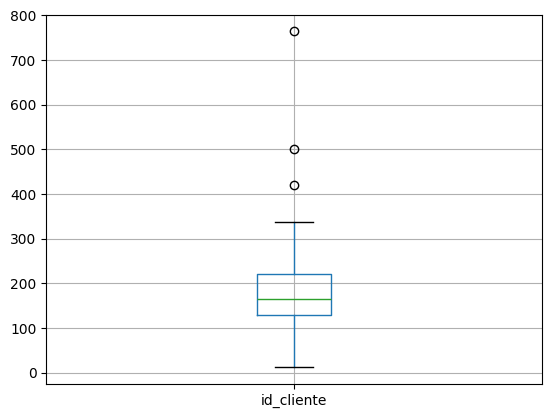

In [0]:
# plotar boxplot para verificar outliers no número de usuários novos
display(usuarios_novos.boxplot(column='id_cliente'))

#### ROAS
Nesta seção iremos fazer o cálculo do retorno sob o investimento em anúncios. 

Premissa: para o cálculo vamos levar em consideração que o investimento mensal em marketing é de R$ 700

In [0]:
# calculando a receita obtida
receita = tabelao['valor_compras'].sum()


In [0]:
# calculando o investimento vezes a quantidade de meses
investimento = tabelao['periodo_consumo'].nunique() * 700

In [0]:
# calculo de roas
roas = (receita - investimento)/investimento
print(f'Para cada real investido em anúncios nos retornou {roas:.2f} reais')

Para cada real investido em anúncios nos retornou 17.28 reais


<p> Sem nenhuma revisão nos dados para o momento, iremos persistir os dados na camada Ouro e em seguida proceder a visualização dos dados!

In [0]:
# persistir na camada ouro
spark.createDataFrame(tabelao).write.mode('overwrite').saveAsTable('gold.tabelao')

## 4️⃣ Visualização de dados
O Dashboard com as principais métricas agregadas e visualizações pertinentes ao negócio. 

[Link permanente do Dash](https://dbc-2563d7e1-8fb9.cloud.databricks.com/dashboardsv3/01f0d1498fc918069f84c4c40e2267da/published?o=2486147837534960)! 

![dashboard](/Volumes/mvp_catalog/mvp_schema/volumes/dashboard_mpv_png.png)

##  5️⃣ Autoavaliação

**Atingimento dos objetivos** 

O principal objetivo deste trabalho foi atingido com sucesso, sendo um pipeline de dados para construir base sólida para análises e insights para campanhas de marketing a partir dos dados de cadastro e comportamento de consumo dos clientes. Conseguimos também, preparamos os dados de forma que sejam visualizados, dando transparência aos sócios, facilitando integração de times de dados, vendas e marketing, além de justificar financeiramente as iniciativas e investimentos neste sentido.

A rotina de tratar os dados já nos é familiar, porém, este trabalho proporcionou melhorias na técnica e aprofundamento ainda maior em relação às boas práticas em matéria de engenharia de dados. 

**Dificuldades**

Não houve tanta dificuldade para implementar, mas foi preciso um cuidado especial em relação à confidencialidade dos dados, antes de darmos início de fato na implementação do presente trabalho.

**Trabalhos futuros**
- Com os dados já limpos e no padrão da camada ouro, é possível partir para outras análises como Análise de Cohort com ênfase na retenção ou receita de cada safra; 
- Análise RFM para segmentar os clientes e setar as melhores campanhas para cada grupo com base na receita, frequência de uso e monetização, personalizando assim as campanhas, aumentando a probabilidade de resposta e adesão às mesmas. 
- Poderemos construir modelos que realizem a predição da receita (com base nessas e outras variáveis) a partir do investimentos em anúncios pagos e setar com mais acurácia o mix ótimo de mídias mais eficaz,
- Além disso, podemos prever através da construção de modelos de machine learning, por exemplo, a demanda dos usuários nos próximos meses, prever aqueles que irão abadonar o serviço.

Todas essas informações apoiam as decisões de negócio e possibilitam a otimização de recursos. 